# $k$-Nearest-Neighbors

> 
>
> **Author:** Bjarne C. Hiller

## Ingredients

- Math
    - Vector Norms and Distance Metrics
- NumPy
    - [Broadcasting in NumPy](https://numpy.org/doc/stable/user/basics.broadcasting.html)
    - `np.argsort`
    - `np.argmax`
    - `np.bincount`
    - `np.apply_along_axis`
- scikit-learn
    - [`sklearn.LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

## Vector Norms

$p$-norm

$$
    \lVert \mathbf{x} \rVert_p = \left( \sum_{i=1}^d x_i^p \right)^{\frac{1}{p}}
$$

For $p=1$, we just add up the individual vector components. Therefore, the norm is known as *Taxicab norm* or *Manhatten norm*, since distances can be visualized by a taxi, that can just drive on orthogonal streets between buildings to get to its destination:

$$
    \lVert \mathbf{x} \rVert_1 = \sum_{i=1}^d \lvert x_i \rvert
$$

For $p=2$, we get the well-known *Euclidean Norm*, that returns the distance of a point to the origin:

$$
    \lVert \mathbf{x} \rVert_2 = \sqrt{\sum_{i=1}^d x_i^2 } = \sqrt{\mathbf{x} \cdot \mathbf{x}}
$$

Using the Euclidean norm, we get the Euclidean Distance, which describes the length of a line segment connecting the 2 points:

$$
    d(\mathbf{x}, \mathbf{y}) = \lVert \mathbf{x} - \mathbf{y} \rVert_2 = \sqrt{\sum_{i=0}^d (x_i - y_i)^2}
$$

> What do we get for $p=\infty$?

We get the *maximum norm*:

$$
    \lVert \mathbf{x} \rVert_\infty = \max_i x_i
$$

In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
import numpy as np

A = np.random.randn(6,2)
B = np.random.randn(4,2)

(A[:, np.newaxis, :] - B).shape

(6, 4, 2)

In [3]:
def distance_matrix(A, B):
    """
    Computes pairwise euclidean distances between points.

    :param A: point array (n, d)
    :param B: point array (m, d)
    :returns: pairwise distance matrix (n,m) 
    """
    # repeat A m times to receive (n,m,d)
    A = A[:, np.newaxis, :]

    # numpy broadcasting magic!
    D = A - B

    # Euclidean Distance
    D = np.power(D, 2)
    D = np.sum(D, axis=-1)
    D = np.sqrt(D)
    return D
    
D = distance_matrix(A, B)

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(["apple", "orange", "pear", "apple"])

array([0, 1, 2, 0])

In [5]:
rank = np.argsort(D, axis=1)[:, :1]

y = np.array(["A", "B", "C", "D", "E", "F"])
y[rank]

array([['C'],
       ['C'],
       ['C'],
       ['B'],
       ['C'],
       ['C']], dtype='<U1')

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=1):
        self.k = k
        # sklearn convention: fields ending on underscores (_) are computed during fit
        self.X_train_ = None
        self.y_train_ = None
        self.classes_ = None
        self.le_ = None
    
    def fit(self, X, y):
        # store training data
        self.X_train_ = X
        self.y_train_ = y
        self.le_ = LabelEncoder()
        self.le_.fit(y)
        self.classes_ = self.le_.classes_
 
    def _predict(self, X):
        """For m points, returns label counts (m,c) over c classes among the k nearest neighbors."""
        # compute pairwise distances between train and test
        D = distance_matrix(X, self.X_train_)

        # get sorted indices
        rank = np.argsort(D, axis=1)

        # use only top k ranks
        rank = rank[:, :self.k]

        # get labels (n,k) associated with k closest train points
        y = self.y_train_[rank]

        # for k>1, we need to count label occurences
        y = np.apply_along_axis(self.le_.transform, 1, y)

        # count label occurences along axis 1
        n = len(self.le_.classes_)
        counts = np.apply_along_axis(np.bincount, 1, y, minlength=n)
        return counts
    
    def predict(self, X):
        """Most frequent label among k nearest neighbors."""
        counts = self._predict(X)
        prediction = np.argmax(counts, axis=1)
        prediction = self.le_.inverse_transform(prediction)
        return prediction
    
    def predict_proba(self, X):
        """Relative label frequencies among k nearest neighbors."""
        counts = self._predict(X)
        return counts / np.sum(counts, axis=1, keepdims=True)

## Visualize Decision Boundaries

For $k=1$, the decision boundary of the KNN presents a [*Voronoi partition*](https://en.wikipedia.org/wiki/Voronoi_diagram) of the feature space given the training points:

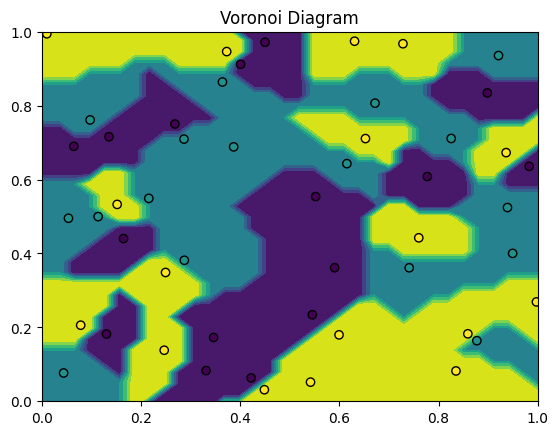

In [7]:
np.random.seed(19)

n = 50


X = np.random.uniform(0, 1, size=(n,2))
y = np.random.choice([1, 2, 3], n)

fig, ax = plt.subplots()

model = KNN(k=1)
model.fit(X, y)

DecisionBoundaryDisplay.from_estimator(model, X, ax=ax)

plt.scatter(X[:,0], X[:,1], c=y, edgecolors=["k"])
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Voronoi Diagram");

## Test on Iris Dataset

In [8]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_ds = load_iris()

# use petal length and petal width as features
X = iris_ds["data"][:,[2,3]]
y = iris_ds["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=19)

In [9]:
from sklearn.metrics import accuracy_score

model = KNN(k=1)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)

accuracy_score(y_test, y_hat)

1.0

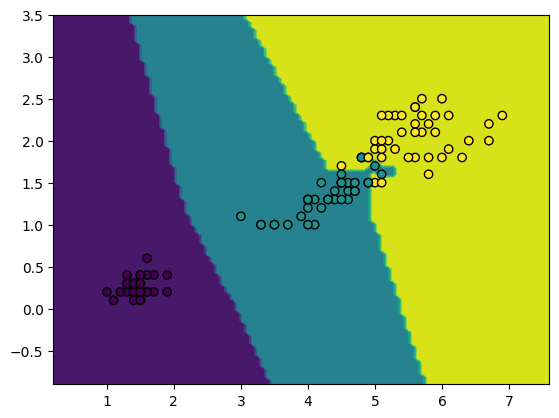

In [10]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = plt.subplots()

display = DecisionBoundaryDisplay.from_estimator(model, X_test, ax=ax)

ax.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors="k")
plt.show()

## Curse of Dimensionality

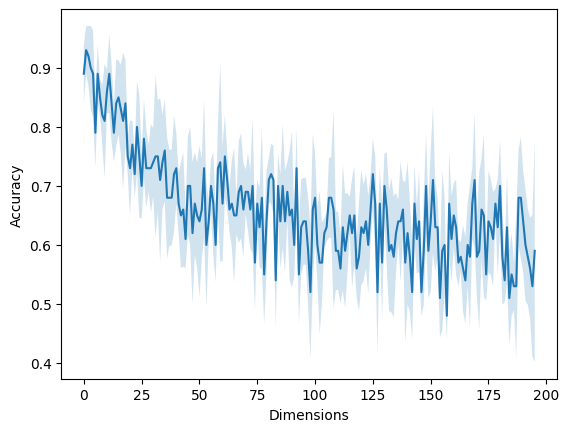

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

scores = []
for d in range(4, 200):
    X, y = make_classification(n_samples=100, n_classes=2, n_features=d, n_informative=2, n_redundant=0, n_repeated=0, random_state=19)
    # model = KNeighborsClassifier(n_neighbors=5)
    model = KNN(k=5)
    score = cross_val_score(model, X, y)
    scores.append(score)

scores = np.stack(scores)
mu = scores.mean(axis=1)
sigma = scores.std(axis=1)

plt.fill_between(x=np.arange(len(mu)), y1=mu-sigma, y2=mu+sigma, alpha=0.2)
plt.plot(scores.mean(axis=1))
plt.xlabel("Dimensions")
plt.ylabel("Accuracy");

## References

- [sklearn KNN](https://scikit-learn.org/stable/modules/neighbors.html#classification)
- [Wikipedia: KNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
- [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram)